# 1. Normalizing Flows

a. Describe the training objective for flows.

The training objective for normalizing flows is minimizing the negative log likelihoods between the model's learned distribution and the actual data distribution.

b. Describe the sampling process of normalizing flows.

The sampling process for normalizing flows is done by sampling from the simple distribution (normally Gaussian) in latent space and applying the backward transformation to generate a sample in the data space.

c. What properties does the transformation function $f_\theta$ must satisfy for practical flow models?

The transformation function must have the same output dimensions as input dimensions, it must be invertible, and the calculation of the determinant of its Jacobian must be differentiable.

# 2. Wasserstein Distance

In many cases, the GAN algorithm can be though of as minimizing a divergence between a data distribution $p_{data}$ and the model distribution $p_g$. In this problem, we will explore an issue with various divergences (e.g., Jensen-Shannon divergence and KL divergence) and one potential way to fix it.

a. Let $p_{data}~\mathcal{N}(\theta_0,\epsilon^2)$ and $p_g~\mathcal{N}(x|\theta,\epsilon^2)$ be normal distributions with standard deviation $\epsilon$ centered at $\theta_0\in\mathbb{R}$ and $\theta\in\mathbb{R}$, respectively. Show that

$$ D_{KL}(p_g||p_{data})=\frac{(\theta-\theta_0)^2}{2\epsilon^2}. $$
By definition:
$$ D_{KL}(p_g||p_{data})=H(p_{data},p_g)-H(p_g) $$

Find $H(p_{data},p_g)$:
\begin{align}
\notag H(p_{data},p_g)&=-\int p_{data}(x)\log p_g(x)dx \\
\notag &=-\int p_{data}(x)\log [\frac{1}{\sqrt{2\pi\epsilon^2}}\exp(-\frac{1}{2\epsilon^2}(x-\theta)^2)]dx \\
\notag &= -\int p_{data}(x)\log\frac{1}{\sqrt{2\pi\epsilon^2}}dx+\int p_{data}(x)\frac{1}{2\epsilon^2}(x-\theta)^2dx \\
\notag &= -\log\frac{1}{\sqrt{2\pi\epsilon^2}}\int p_{data}(x)dx + \frac{1}{2\epsilon^2}\int p_{data}(x)(x-\theta)^2dx \\
\notag &= -\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2\epsilon^2}\left[\int p_{data}(x)x^2dx + \int p_{data}(x)(-2\theta x)dx + \int p_{data}(x)\theta^2dx\right] \\
\notag &= -\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2\epsilon^2}\left[ \theta_0^2+\epsilon^2-2\theta\theta_0+\theta^2 \right] \\
\notag &=  -\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2} + \frac{(\theta-\theta_0)^2}{2\epsilon^2}\\
\end{align}

Find $H(p_g)$:
\begin{align}
\notag H(p_g)&=-\int p_g(x)\log p_g(x)dx \\
\notag &=-\int p_g(x)\log [\frac{1}{\sqrt{2\pi\epsilon^2}}\exp(-\frac{1}{2\epsilon^2}(x-\theta)^2)]dx \\
\notag &= -\int p_g(x)\log\frac{1}{\sqrt{2\pi\epsilon^2}}dx+\int p_g(x)\frac{1}{2\epsilon^2}(x-\theta)^2dx \\
\notag &= -\log\frac{1}{\sqrt{2\pi\epsilon^2}}\int p_g(x)dx + \mathbb{E}\frac{1}{2\epsilon^2}(x-\theta)^2 \\
\notag &= -\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2} \\
\end{align}


Solve for $D_{KL}(p_g||p_{data})$:
\begin{align}
\notag D_{KL}(p_g||p_{data})&=H(p_{data},p_g)-H(p_g) \\
\notag &=-\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2} + \frac{(\theta-\theta_0)^2}{2\epsilon^2}-\left(-\log\frac{1}{\sqrt{2\pi\epsilon^2}} + \frac{1}{2}\right) \\
\notag &=\frac{(\theta-\theta_0)^2}{2\epsilon^2} \\
\end{align}

---

b. Suppose $p_{data}$ and $p_g$ both place probability mass in only a very small part of the domain; that is, consider the limit $\epsilon\rightarrow0$. What happens to $D_{KL}(p_g||p_{data})$ and its derivative with respect to $\theta$, assuming that $\theta\neq\theta_0$?

$$ \lim_{\epsilon\rightarrow 0}\frac{(\theta-\theta_0)^2}{2\epsilon^2}=\infty$$

The KL Divergence approaches infinity and the derivative approaches $0$.

---

c. Would this pose an issue for a GAN trained with the loss function defined below? Why?

$$ L_G(\theta;\phi)=\mathbb{E}_{x~p_\theta(x)}[\log(1-D_\phi(x))]-\mathbb{E}_{x~p_\theta(x)}[\log D_\phi(x)] $$

Yes, this poses an issue for a GAN trained with this loss function because as its gradient approaches zero, the network weights will not update and fail to converge.

---

d. Under the same circumstances as (b), compare KL divergence, JS divergence and Wasserstein Distance.

Both KL divergence and JS divergence suffer from this issue, but not Wasserstein Distance. This is because Wasserstein distance captures the degree of divergence between two distributions even if they are completely disjoint.

# 3. Wasserstein GAN for MNIST

In this question, you will train a Wasserstein GAN on the MNIST dataset, which comprises $28\times28$ grayscale images.

a. Implement the optimization process for the Wasserstein GAN. Consider making multiple updates (e.g., 2) to the discriminator for each update to the generator.

b. Train your model for 40 epochs (we recommend using a learning rate of lr=3e-4). After training, the generated samples should resemble the results shown below.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt
import einops
from torchmetrics.image.inception import InceptionScore
import warnings

In [3]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, pkl='mnist.pkl', phase='train'):
        with open(pkl, 'rb') as f:
            mnist = pickle.load(f)
        self.img = mnist[phase]
        self.img = torch.tensor(self.img).reshape((-1, 1, 28, 28))
        self.label = torch.tensor(mnist[f'{phase}_labels'])

    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, ndx):
        img = (self.img[ndx] / 127.5) - 1
        # img = self.img[ndx] / 255.
        # img = self.img[ndx].float()
        label = self.label[ndx]
        return img, label

In [4]:
class G(nn.Module):
    def __init__(self, batch_size=1, latent_dim=16, device='cpu'):
        super().__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 28*28*1), nn.ReLU(),
            nn.Linear(28*28*1, 28*28*2), nn.ReLU(),
            # nn.Linear(28*28*2, 28*28*3), nn.ReLU(),
            # nn.Linear(28*28*3, 28*28*4), nn.ReLU(),
            nn.Linear(28*28*2, 28*28), nn.Tanh(),
        ).to(device)

    def forward(self, z=None):
        if z is None:
            z = torch.randn((self.batch_size, self.latent_dim)).to(self.device)
        return self.net(z).reshape((-1, 28, 28))
    

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 28*28), nn.ReLU(),
            # nn.Linear(28*28*4, 28*28*4), nn.ReLU(),
            # nn.Linear(28*28, 28*28), nn.ReLU(),
            nn.Linear(28*28, 1), nn.Sigmoid(),
        )

    def forward(self, img):
        return self.net(torch.flatten(img, start_dim=1)).squeeze(-1)
    


In [5]:
class GAN:
    def __init__(self, batch_size=1, latent_dim=16, device='cpu'):
        # self.batch_size=batch_size
        self.device = device
        self.g = G(batch_size, latent_dim=latent_dim, device=device)
        self.d = D().to(device)
        self.g_optim = torch.optim.Adam(self.g.parameters(), lr=3e-4)
        self.d_optim = torch.optim.Adam(self.d.parameters(), lr=3e-4)
        self.loss_fn = torch.nn.BCELoss()

    def iterate(self, real_img, d_ratio=2):
        # UPDATE G
        for p in self.d.parameters():
            p.requires_grad = False
        for p in self.g.parameters():
            p.requires_grad = True

        self.g_optim.zero_grad()
        fake_img = self.g()
        ones = torch.ones(fake_img.shape[0]).to(self.device)
        fake_lbl_pred = self.d(fake_img)
        g_loss = self.loss_fn(fake_lbl_pred, ones)
        g_loss.backward()
        self.g_optim.step()

        # UPDATE D
        for _ in range(d_ratio):
            for p in self.d.parameters():
                p.requires_grad = True
            for p in self.g.parameters():
                p.requires_grad = False

            self.d_optim.zero_grad()
            zeros = torch.zeros(fake_img.shape[0]).to(self.device)
            fake_lbl_pred = self.d(fake_img.detach())
            d_loss_fake = self.loss_fn(fake_lbl_pred, zeros)

            ones = torch.ones(real_img.shape[0]).to(self.device)
            real_lbl_pred = self.d(real_img)
            d_loss_real = self.loss_fn(real_lbl_pred, ones)

            d_loss = (d_loss_real + d_loss_fake) / 2.
            d_loss.backward()
            self.d_optim.step()

        print(f'g {g_loss:.2f} | d_real {d_loss_real:.2f} | d_fake {d_loss_fake:.2f}', end='\r')


In [6]:
class WassersteinLoss(nn.Module):
    def forward(self, fake, real):
        return fake.mean() - real.mean()

class WGAN:
    def __init__(self, batch_size=1, latent_dim=16, lr=1e-5, device='cpu', gradient_clipping=(-0.01, 0.01)):
        self.batch_size=batch_size
        self.device = device
        self.gradient_clipping = gradient_clipping
        self.g = G(batch_size, latent_dim=latent_dim, device=device)
        self.d = D().to(device)
        self.g_optim = torch.optim.RMSprop(self.g.parameters(), lr=lr)
        self.d_optim = torch.optim.RMSprop(self.d.parameters(), lr=lr)
        self.loss_fn = WassersteinLoss()

    def iterate(self, real_img, d_ratio=2):
        # UPDATE G
        for p in self.d.parameters():
            p.requires_grad = False
        for p in self.g.parameters():
            p.requires_grad = True

        self.g_optim.zero_grad()
        fake_img = self.g()
        fake_lbl_pred = self.d(fake_img)
        g_loss = 1 - fake_lbl_pred.mean()
        g_loss.backward()
        self.g_optim.step()

        # UPDATE D
        for _ in range(d_ratio):
            for p in self.d.parameters():
                p.requires_grad = True
            for p in self.g.parameters():
                p.requires_grad = False

            self.d_optim.zero_grad()
            fake_lbl_pred = self.d(fake_img.detach())
            real_lbl_pred = self.d(real_img)

            d_loss = 1 + fake_lbl_pred.mean() - real_lbl_pred.mean()
            d_loss.backward()
            self.d_optim.step()

            for p in self.d.parameters():
                p.data.clamp_(*self.gradient_clipping)

        print(f'g {g_loss:.2f} | d {d_loss:.2f}', end='\r')
        

In [7]:
DEVICE='cuda:0'
N_EPOCH = 40
BATCH_SIZE = 1024
LATENT_DIM = 16
LR=1e-5
ds = MNISTDataset()
dl = DataLoader(ds, BATCH_SIZE, shuffle=True)
gan = WGAN(batch_size=BATCH_SIZE, latent_dim=LATENT_DIM, lr=LR, device=DEVICE)

In [8]:
for epoch_ndx in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch_ndx:02d}')
    for batch in dl:
        real_img = batch[0].to(DEVICE)
        gan.iterate(real_img)
    print()

EPOCH 01
g 0.29 | d 0.85
EPOCH 02
g 0.23 | d 0.95
EPOCH 03
g 0.22 | d 0.98
EPOCH 04
g 0.23 | d 0.99
EPOCH 05
g 0.27 | d 0.99
EPOCH 06
g 0.37 | d 0.98
EPOCH 07
g 0.43 | d 0.97
EPOCH 08
g 0.47 | d 0.96
EPOCH 09
g 0.49 | d 0.96
EPOCH 10
g 0.50 | d 0.95
EPOCH 11
g 0.51 | d 0.94
EPOCH 12
g 0.51 | d 0.94
EPOCH 13
g 0.51 | d 0.94
EPOCH 14
g 0.50 | d 0.94
EPOCH 15
g 0.49 | d 0.94
EPOCH 16
g 0.47 | d 0.94
EPOCH 17
g 0.45 | d 0.95
EPOCH 18
g 0.44 | d 0.95
EPOCH 19
g 0.43 | d 0.95
EPOCH 20
g 0.41 | d 0.95
EPOCH 21
g 0.40 | d 0.96
EPOCH 22
g 0.40 | d 0.95
EPOCH 23
g 0.41 | d 0.96
EPOCH 24
g 0.39 | d 0.97
EPOCH 25
g 0.39 | d 0.96
EPOCH 26
g 0.41 | d 0.96
EPOCH 27
g 0.41 | d 0.96
EPOCH 28
g 0.41 | d 0.96
EPOCH 29
g 0.42 | d 0.96
EPOCH 30
g 0.42 | d 0.96
EPOCH 31
g 0.42 | d 0.97
EPOCH 32
g 0.42 | d 0.97
EPOCH 33
g 0.36 | d 0.99
EPOCH 34
g 0.34 | d 1.00
EPOCH 35
g 0.43 | d 0.99
EPOCH 36
g 0.48 | d 0.94
EPOCH 37
g 0.46 | d 0.95
EPOCH 38
g 0.41 | d 0.97
EPOCH 39
g 0.40 | d 0.98
EPOCH 40
g 0.41 | d 0.98


## Request deliverables:

a. Provide 100 samples from your trained WGAN.

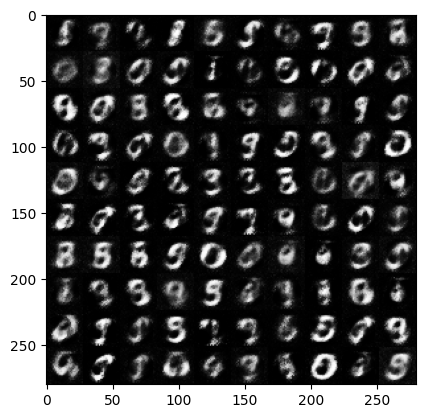

In [9]:
gan.g.eval()
with torch.no_grad():
    fake = gan.g().cpu()[:100]

x_pred = einops.rearrange(fake, '(img_h img_w) h w -> (img_h h) (img_w w)', img_h=10)
im = plt.imshow(x_pred, 'gray')
# plt.colorbar(im)
plt.show()

b. Report the Inception Score (https://github.com/openai/improved-gan/tree/master/inception_score).

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inception_score = InceptionScore()
inception_score.update(((fake + 1) * 127.5).to(torch.uint8).unsqueeze(1).repeat(1, 3, 1, 1))
IS, IS_STD = inception_score.compute()
print(f'Inception Score: {IS:.4f} with standard deviation {IS_STD:.4f}')

Inception Score: 2.1056 with standard deviation 0.2129



c. Include Interpolations between two random latent variables. 
 


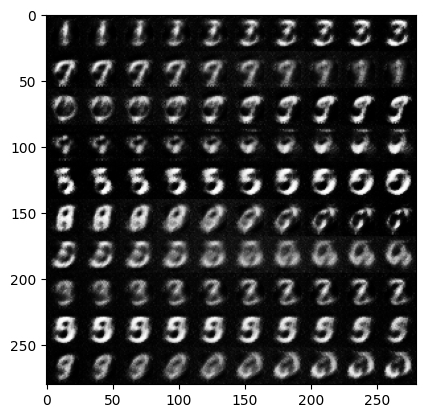

In [11]:
latent = torch.empty((10, 10, gan.g.latent_dim)).to(DEVICE)
latent[0] = torch.normal(mean=torch.zeros((10, gan.g.latent_dim)), std=torch.ones((10, gan.g.latent_dim)))
latent[-1] = torch.normal(mean=torch.zeros((10, gan.g.latent_dim)), std=torch.ones((10, gan.g.latent_dim)))
for i in range(1,10):
    latent[i] = torch.lerp(latent[0], latent[-1], i * 0.1)
latent.reshape((100, gan.g.latent_dim))

gan.g.batch_size = 100

gan.g.eval()
with torch.no_grad():
    fake = gan.g(latent).cpu()

x_pred = einops.rearrange(fake, '(img_h img_w) h w -> (img_w h) (img_h w)', img_h=10)
im = plt.imshow(x_pred, 'gray')
# plt.colorbar(im)
plt.show()